In [52]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage.io import imread, imshow
from skimage.color import rgb2gray
from skimage.exposure import rescale_intensity, equalize_hist
from skimage.filters import threshold_otsu
from skimage.measure import regionprops

In [55]:
#CONSTANTS
IMAGE = imread("lava_lamp.jpeg")

In [3]:
def get_available_cameras():
    available_cameras = []
    # Check for 5 cameras 
    for i in range(5):
        cap = cv2.VideoCapture(i)
        if cap.isOpened():
            available_cameras.append(i)
            cap.release()
    return available_cameras

cameras = get_available_cameras()
if cameras:
    print("Available Cameras:", cameras)
else:
    print("No cameras found.")

Available Cameras: [0, 1]


In [50]:
def image_adjust(frame):
    #Saturation
    hue_shift = 0
    sat_scale = 1.2
    hsv = cv2.cvtColor(frame, cv2.COLOR_RGB2HSV).astype(np.float32)
    hsv[..., 0] = np.clip(hsv[..., 0] + hue_shift, 0, 179)  # Adjust Hue (0-179 for OpenCV)
    hsv[..., 1] = np.clip(hsv[..., 1] * sat_scale, 0, 255)  # Scale Saturation
    frame_adjusted = cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2RGB)

    #Contrast
    img = rgb2gray(frame_adjusted)
    return equalize_hist(img) 
    
def convert_to_binary(frame):
    edited_frame = image_adjust(frame)
    threshold = 0.6
    binary_image = edited_frame > threshold
    return binary_image

def create_combined_window(frames_dict, target_width=800):
    """Combine multiple frames into a single window with resizing"""
    # Get the size of the first frame for reference
    first_frame = next(iter(frames_dict.values()))
    height, width = first_frame.shape[:2]
    
    # Calculate new dimensions maintaining aspect ratio
    target_height = int(target_width * height / width)
    
    # Create a blank canvas to hold all frames
    combined = np.zeros((target_height, target_width * len(frames_dict), 3), dtype=np.uint8)
    
    # Add each frame to the canvas
    for idx, (name, frame) in enumerate(frames_dict.items()):
        # Resize frame
        resized_frame = cv2.resize(frame, (target_width, target_height))
        
        # Convert grayscale to BGR if needed
        if len(resized_frame.shape) == 2:
            resized_frame = cv2.cvtColor(resized_frame, cv2.COLOR_GRAY2BGR)
        
        # Add frame to canvas
        combined[:, idx*target_width:(idx+1)*target_width] = resized_frame
        
        # Add label
        cv2.putText(combined, name, (idx*target_width + 10, 30), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    
    return combined

In [49]:
cap = cv2.VideoCapture(1)
while True:
    ret, frame = cap.read()
    if not ret:
        print("Failed!")
        break

    conv_frame = convert_to_binary(frame)  # Your binary conversion function

    # Combine frames into single window
    # ...existing code...
# In your main loop, use the modified create_combined_window function:
    combined = create_combined_window(
        {
            "Original": frame,
            "Binary": cv2.cvtColor(conv_frame.astype(np.uint8) * 255, cv2.COLOR_GRAY2BGR)
        },
        target_width=640  # Adjust this value to change the size of each window
    )

    # Show single window with both frames
    cv2.imshow("Lava Lamp Detection", combined)

    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

cap.release()
cv2.destroyAllWindows()

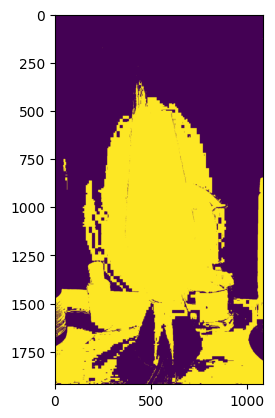

In [ ]:
binary_image = convert_to_binary(IMAGE)
plt.imshow(binary_image, cmap='gray')

(< cv2.KeyPoint 0000018EA5FD06F0>, < cv2.KeyPoint 0000018EA7CA9140>, < cv2.KeyPoint 0000018EA7D2B870>, < cv2.KeyPoint 0000018EA606AC10>, < cv2.KeyPoint 0000018EA6DB0600>, < cv2.KeyPoint 0000018EA6D0C120>, < cv2.KeyPoint 0000018EA6CBA370>, < cv2.KeyPoint 0000018EA6CA05A0>, < cv2.KeyPoint 0000018EA8107F30>, < cv2.KeyPoint 0000018EA8107F60>, < cv2.KeyPoint 0000018EA8107300>, < cv2.KeyPoint 0000018EA81078A0>, < cv2.KeyPoint 0000018EA8107A20>, < cv2.KeyPoint 0000018EA7B15C80>, < cv2.KeyPoint 0000018EA7C88270>, < cv2.KeyPoint 0000018EA7C89590>, < cv2.KeyPoint 0000018EA7CC6940>, < cv2.KeyPoint 0000018EA7D6E790>, < cv2.KeyPoint 0000018EA7AAD710>, < cv2.KeyPoint 0000018EA8128300>, < cv2.KeyPoint 0000018EA8129290>, < cv2.KeyPoint 0000018EA812BB70>)


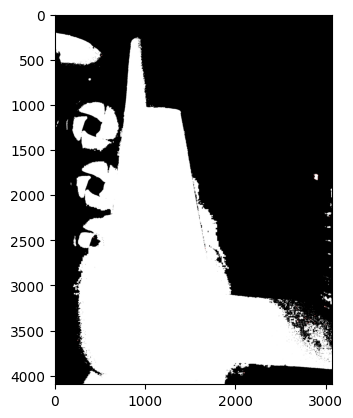

In [53]:
binary_image = convert_to_binary(IMAGE)

plt.show()  
def detect_blobs(binary_image):
    conv_binary_img = binary_image.astype(np.uint8) * 255
    params = cv2.SimpleBlobDetector_Params()
    
    # Filter by Area
    params.filterByArea = True
    params.maxArea = 100000
    
    params.filterByColor = True
    params.blobColor = 255
    
    # Filter by Circularity
    params.filterByCircularity = True
    params.minCircularity = 0.5   # Increase for more circular blobs
    
    # Filter by Convexity
    params.filterByConvexity = True
    params.minConvexity = 0.5
    
    # Filter by Inertia
    params.filterByInertia = True
    params.minInertiaRatio = 0.3  # Adjust for elongated blobs
    
    # Important: Set blob color to detect dark blobs
    
    detector = cv2.SimpleBlobDetector_create(params)
    
    # Detect blobs
    keypoints = detector.detect(conv_binary_img)
    
    # Draw keypoints
    img_with_keypoints = cv2.drawKeypoints(conv_binary_img, keypoints, np.array([]), 
                                         (255, 0, 0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    return img_with_keypoints, keypoints

imgKey, key = detect_blobs(binary_image)
plt.imshow(imgKey)
print(key)